In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
os.chdir(r"C:\Users\User\OneDrive\Документы\Kaggle\kaggle\Breast Cancer US Classification")

C:\Users\User\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import torch.nn as nn
import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import torchvision
from torchvision import transforms
from torchvision.io import read_image
from PIL import Image
import os
from pathlib import Path

In [3]:
img = read_image(r"C:\Users\User\OneDrive\Документы\Kaggle\kaggle\Breast Cancer US Classification\training_set\benign\benign (1)_mask.png")

In [4]:
img = img.permute(1, 2, 0)

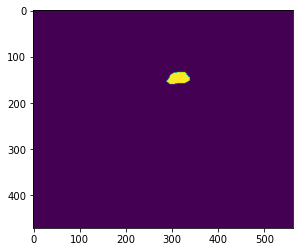

In [5]:
plt.imshow(img)

In [6]:
transform = transforms.Compose([
    transforms.Resize((256, 256)), 
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


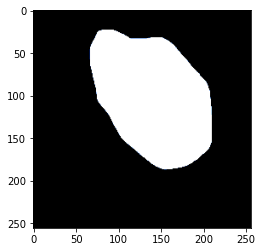

In [83]:
imag = Image.open(Path(r"C:\Users\User\OneDrive\Документы\Kaggle\kaggle\Breast Cancer US Classification\training_set") / "benign" / "benign (393)_mask.png")
imag = transform(imag.convert("RGB"))
plt.imshow(np.array(imag, dtype=float).transpose(1, 2, 0))

In [8]:
np.array(imag, dtype=float).shape

(3, 256, 256)

In [9]:
class MedicalImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.classes = ['benign', 'malignant']
        self.samples = []
        
        for class_idx, class_name in enumerate(self.classes):
            class_dir = self.root_dir / class_name
            for img_name in os.listdir(class_dir):
                if img_name.endswith('_mask.png'):
                    self.samples.append((class_dir / img_name, class_idx))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        return image, torch.tensor(label, dtype=torch.long)

In [10]:
dataset = MedicalImageDataset(root_dir=r"C:\Users\User\OneDrive\Документы\Kaggle\kaggle\Breast Cancer US Classification\training_set", transform=transform)

In [11]:
dataset.samples[:5]

[(WindowsPath('C:/Users/User/OneDrive/Документы/Kaggle/kaggle/Breast Cancer US Classification/training_set/benign/benign (1)_mask.png'),
  0),
 (WindowsPath('C:/Users/User/OneDrive/Документы/Kaggle/kaggle/Breast Cancer US Classification/training_set/benign/benign (10)_mask.png'),
  0),
 (WindowsPath('C:/Users/User/OneDrive/Документы/Kaggle/kaggle/Breast Cancer US Classification/training_set/benign/benign (100)_mask.png'),
  0),
 (WindowsPath('C:/Users/User/OneDrive/Документы/Kaggle/kaggle/Breast Cancer US Classification/training_set/benign/benign (101)_mask.png'),
  0),
 (WindowsPath('C:/Users/User/OneDrive/Документы/Kaggle/kaggle/Breast Cancer US Classification/training_set/benign/benign (102)_mask.png'),
  0)]

In [12]:
img, label = dataset[6]
print(img, label)

tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


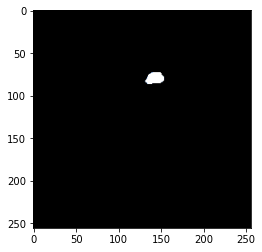

In [13]:
image = dataset.__getitem__(0)
image = image[0].permute(1, 2, 0)
plt.imshow(image)

In [14]:
train_ds, val_ds = random_split(dataset, [0.8, 0.2])
print(len(train_ds), len(val_ds))

438 109


In [15]:
batch_size = 32

In [16]:
torch.manual_seed(42)

In [17]:
train_dl = DataLoader(train_ds, batch_size)
val_dl = DataLoader(val_ds, batch_size)

In [18]:
model = nn.Sequential()
model.add_module(
    "conv1",
    nn.Conv2d(
        in_channels=3, out_channels=32,
        kernel_size=5, padding=2
    )
)
model.add_module("relu1", nn.ReLU())
model.add_module("pool1", nn.MaxPool2d(kernel_size=2))
model.add_module(
    "conv2",
    nn.Conv2d(
        in_channels=32, out_channels=64,
        kernel_size=5, padding=2
    )
)
model.add_module("relu2", nn.ReLU())
model.add_module("pool2", nn.MaxPool2d(kernel_size=2))
model.add_module(
    "conv3",
    nn.Conv2d(
        in_channels=64, out_channels=128,
        kernel_size=5, padding=2
    )
)
model.add_module("relu3", nn.ReLU())
model.add_module("globalavrg", nn.AdaptiveAvgPool2d(output_size=(1, 1)))
model.add_module("flatten", nn.Flatten()) 
model.add_module("fc1", nn.Linear(128, 64))
model.add_module("relu4", nn.ReLU())
model.add_module("drop", nn.Dropout(p=0.5))
model.add_module("fc2", nn.Linear(64, 1))
model.add_module("sigma", nn.Sigmoid())

In [19]:
X = torch.ones(4, 3, 256, 256)
model(X).shape

torch.Size([4, 1])

In [65]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [64]:
for layer in model.children():
   if hasattr(layer, 'reset_parameters'):
       layer.reset_parameters()

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
device

device(type='cuda')

In [26]:
def train(model, n_epochs, train_dl, val_dl):
    loss_hist_train = [0] * n_epochs
    loss_hist_val = [0] * n_epochs
    accuracy = [0] * n_epochs
    for epoch in range(n_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            pred = model(x_batch).squeeze(1)
            loss = loss_fn(pred, y_batch.float())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item() * y_batch.size(0)
        loss_hist_train[epoch] = loss_hist_train[epoch] / len(train_dl.dataset)
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in val_dl:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                pred = model(x_batch).squeeze(1)
                loss = loss_fn(pred, y_batch.float())
                loss_hist_val[epoch] = loss.item() * y_batch.size(0)
                accuracy[epoch] += (torch.round(pred) == y_batch).sum().float()
        loss_hist_val[epoch] = loss_hist_val[epoch] / len(val_dl.dataset)
        accuracy[epoch] /= len(val_dl.dataset)
        if epoch % 10 == 0:
                print(f"Epoch: {epoch}, Training loss: {loss_hist_train[epoch]}, Validation Loss: {loss_hist_val[epoch]}, Accuracy: {accuracy[epoch]}")
    return loss_hist_train, loss_hist_val, accuracy            

In [66]:
n_epochs = 140
hist = train(model, n_epochs, train_dl, val_dl)

Epoch: 0, Training loss: 0.6289994801016159, Validation Loss: 0.06978365587531973, Accuracy: 0.6880733370780945
Epoch: 10, Training loss: 0.50685310418203, Validation Loss: 0.04757816556396834, Accuracy: 0.7339448928833008
Epoch: 20, Training loss: 0.49284375231015626, Validation Loss: 0.051892886741445696, Accuracy: 0.7431192398071289
Epoch: 30, Training loss: 0.4933751971209975, Validation Loss: 0.048744749858838705, Accuracy: 0.7247706055641174
Epoch: 40, Training loss: 0.4969921397836241, Validation Loss: 0.052794546982563965, Accuracy: 0.7431192398071289
Epoch: 50, Training loss: 0.5029766277907646, Validation Loss: 0.04807072084978086, Accuracy: 0.7614678740501404
Epoch: 60, Training loss: 0.4767857809044999, Validation Loss: 0.046256100912706564, Accuracy: 0.7798165082931519
Epoch: 70, Training loss: 0.4198349348214119, Validation Loss: 0.032940843236555745, Accuracy: 0.7981650829315186
Epoch: 80, Training loss: 0.3935266750860432, Validation Loss: 0.034157565974314276, Accuracy

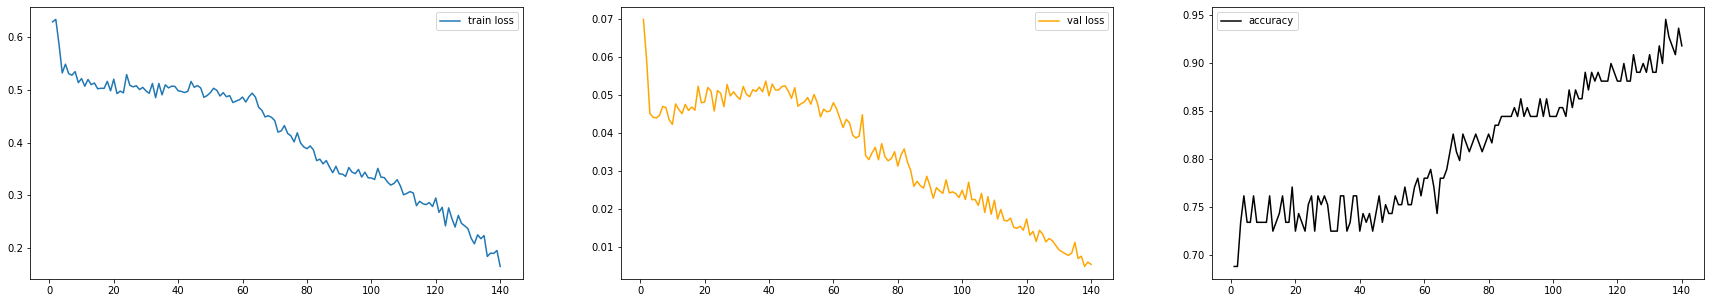

In [169]:
fig, ax = plt.subplots(1, 3, figsize=(30, 5))
ax[0].plot(range(1, n_epochs+1), hist[0], label="train loss")
ax[0].legend()
ax[1].plot(range(1, n_epochs+1), hist[1], label="val loss", color="orange")
ax[1].legend()
ax[2].plot(range(1, n_epochs+1), [row.cpu().numpy() for row in hist[2]], label="accuracy", color="black")
ax[2].legend()

In [93]:
imag_inf = imag.to(device).unsqueeze(0)
imag_inf.size()

torch.Size([1, 3, 256, 256])

In [137]:
with torch.no_grad():
    model.eval()
    print(model(imag_inf).cpu().numpy().squeeze())

0.4461652


In [164]:
def predict(path):
    preds = []
    model.eval()
    with torch.no_grad():
        for img_name in os.listdir(path):
            if img_name.endswith('_mask.png'):
                img_id = "T" + img_name.split('_')[0][1: 4]
                image = Image.open(path + "\\" + img_name)
                image = transform(image.convert("RGB")).to(device).unsqueeze(0)
                preds.append((img_id, model(image).cpu().numpy().squeeze()))
    return preds

In [165]:
predictions = predict(r"C:\Users\User\OneDrive\Документы\Kaggle\kaggle\Breast Cancer US Classification\complete_set\testing_set")
predictions

[('T001', array(0.98354554, dtype=float32)),
 ('T002', array(0.9422778, dtype=float32)),
 ('T003', array(0.1183634, dtype=float32)),
 ('T004', array(0.9758449, dtype=float32)),
 ('T005', array(0.94727606, dtype=float32)),
 ('T006', array(0.12264517, dtype=float32)),
 ('T007', array(0.0720505, dtype=float32)),
 ('T008', array(0.07039054, dtype=float32)),
 ('T009', array(0.08192508, dtype=float32)),
 ('T010', array(0.11068688, dtype=float32)),
 ('T011', array(0.02753751, dtype=float32)),
 ('T012', array(0.31959963, dtype=float32)),
 ('T013', array(0.18420489, dtype=float32)),
 ('T014', array(0.07162917, dtype=float32)),
 ('T015', array(0.118033, dtype=float32)),
 ('T016', array(0.0314346, dtype=float32)),
 ('T017', array(0.01360102, dtype=float32)),
 ('T018', array(0.97970635, dtype=float32)),
 ('T019', array(0.88733673, dtype=float32)),
 ('T020', array(0.02033729, dtype=float32)),
 ('T021', array(0.01848752, dtype=float32)),
 ('T022', array(0.09696539, dtype=float32)),
 ('T023', array(0

In [166]:
predictions = pd.DataFrame(predictions, columns=["ID", "Predicted"])
predictions.to_csv("CNN.csv", index=False)

In [167]:
torch.save(model, "dnn.pt")